<center><h2>Projeto final de Machine Learning</h2></center>
<center><h3>Previsão de receita de filmes</h3></center>
<br />
<center>Alunos: Gabriela Caruso, Guilherme Roccato e Pedro Paulo Telho</center>



# Introdução

<p style="text-align: justify" align="justify">A indústria cinematográfica é reconhecida por suas diversas obras primas. Prêmios como Oscar, Globo de Ouro e Emmy são apenas alguns dos que recompensam os seus atores, diretores, produtores etc. Além disso, muito dinheiro é movimentado tanto em forma de investimento para a produção dos filmes como em forma de receita após o lançamento.</p>

<p style="text-align: justify" align="justify">Nesse contexto, o objetivo do projeto é prever quanto de receita um filme pode gerar para que não se tenha prejuízo durante suas produções.</p>
<p style="text-align: justify" align="justify">Para isso, será criado um modelo de regressão através da base de dados: <a href="https://www.kaggle.com/tmdb/tmdb-movie-metadata/version/2?select=tmdb_5000_movies.csv" >TMDb 5000 movies dataset</a></p>

# Metodologia

<p style="text-align: justify" align="justify">Nessa seção será apresentada a forma em que o modelo foi construído: bibliotecas necessárias, exploração dos dados e técnicas de inferência para definição do melhor modelo de machine learning para o problema.</p>

### Importando bibliotecas necessárias:

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys

import numpy as np
import scipy.sparse

import sklearn.linear_model
import sklearn.datasets
import sklearn.svm
import sklearn.metrics
import sklearn.decomposition
import sklearn.feature_extraction.text
import sklearn.utils.sparsefuncs

import logging

import json

In [65]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### Carregando os dados:

In [66]:
movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")

In [67]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


Mesclando créditos e filmes:

In [68]:
credits = credits[['movie_id', 'cast', 'crew']]
credits = credits.rename(columns = {'movie_id': 'id'})
movies = pd.merge(movies,credits,on='id',how='left')

In [69]:
movies_copy = movies.copy()

In [70]:
movies_copy.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


Selecionando apenas filmes lançados:

In [71]:
movies_copy = movies_copy.drop(movies_copy[movies_copy.status != 'Released'].index)

Deletando features que não são interessantes para a análise:

In [72]:
movies_copy = movies_copy.drop(columns={'homepage', 'id', 'original_title', 'tagline', 'status', 'crew'})

## Exploração de dados

In [73]:
movies_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4795 entries, 0 to 4802
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4795 non-null   int64  
 1   genres                4795 non-null   object 
 2   keywords              4795 non-null   object 
 3   original_language     4795 non-null   object 
 4   overview              4792 non-null   object 
 5   popularity            4795 non-null   float64
 6   production_companies  4795 non-null   object 
 7   production_countries  4795 non-null   object 
 8   release_date          4794 non-null   object 
 9   revenue               4795 non-null   int64  
 10  runtime               4793 non-null   float64
 11  spoken_languages      4795 non-null   object 
 12  title                 4795 non-null   object 
 13  vote_average          4795 non-null   float64
 14  vote_count            4795 non-null   int64  
 15  cast                 

Deletando linhas com valores nulos ou zerados:

In [74]:
movies_copy = movies_copy.dropna()

In [75]:
movies_copy = movies_copy[(movies_copy[['budget', 'revenue', 'runtime', 'vote_count']] != 0).all(axis=1)]

### Dataset limpo:

In [76]:
movies_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3226 entries, 0 to 4798
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                3226 non-null   int64  
 1   genres                3226 non-null   object 
 2   keywords              3226 non-null   object 
 3   original_language     3226 non-null   object 
 4   overview              3226 non-null   object 
 5   popularity            3226 non-null   float64
 6   production_companies  3226 non-null   object 
 7   production_countries  3226 non-null   object 
 8   release_date          3226 non-null   object 
 9   revenue               3226 non-null   int64  
 10  runtime               3226 non-null   float64
 11  spoken_languages      3226 non-null   object 
 12  title                 3226 non-null   object 
 13  vote_average          3226 non-null   float64
 14  vote_count            3226 non-null   int64  
 15  cast                 

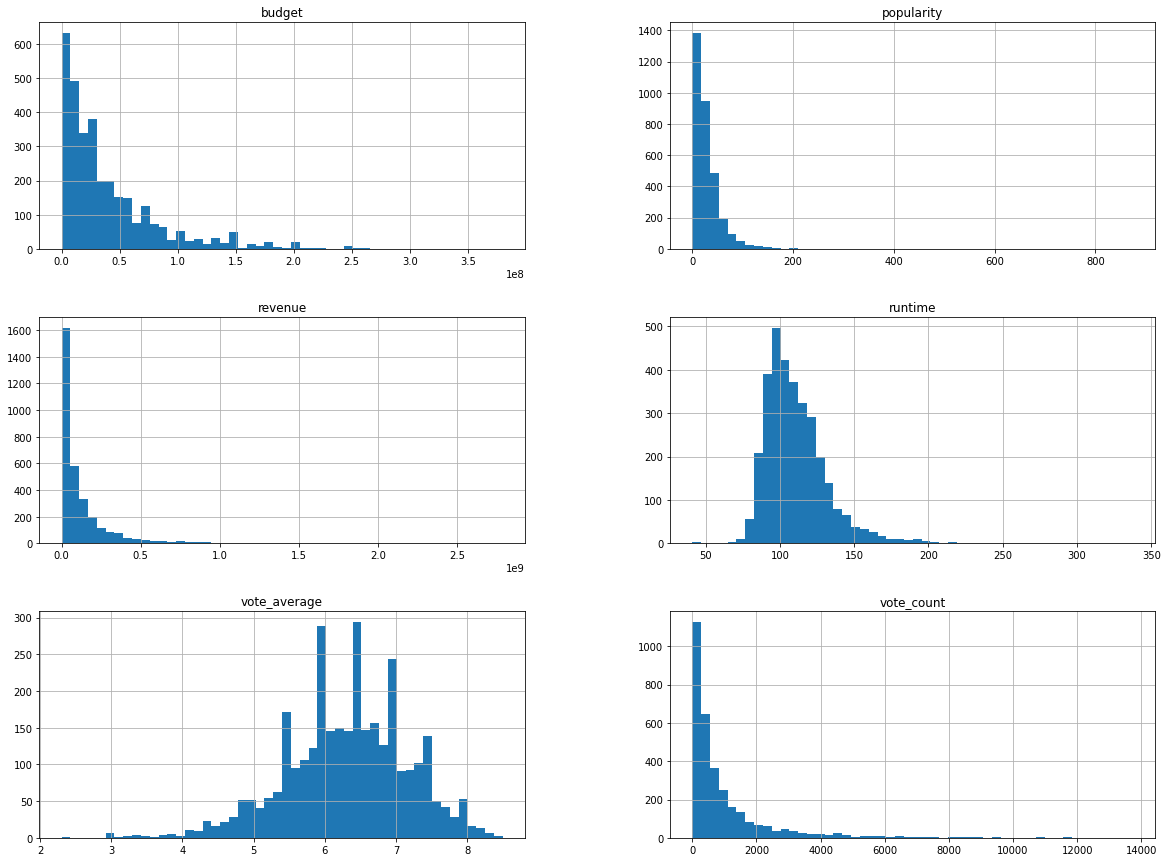

In [77]:
movies_copy.hist(bins=50, figsize=(20, 15))
plt.show()

Visualizando os histogramas acima é possível perceber que não há nenhuma anomalia com a base de dados e, portanto, é posssível continuar com a análise sem nenhuma necessidade de manipulação.

In [78]:
correlation_matrix = movies_copy.corr()

Com a matriz de correlação abaixo pode-se inferir também que a receita de cada filme tem maior correlação com a quantidade de votos (~0.756).

In [79]:
correlation_matrix

,budget,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.431629,0.705260,0.229717,-0.036087,0.539916
popularity,0.431629,1.000000,0.602063,0.182385,0.288001,0.748965
revenue,0.705260,0.602063,1.000000,0.233235,0.187830,0.756110
runtime,0.229717,0.182385,0.233235,1.000000,0.386253,0.258103
vote_average,-0.036087,0.288001,0.187830,0.386253,1.000000,0.380685
vote_count,0.539916,0.748965,0.756110,0.258103,0.380685,1.000000


Uma possível razão para tal é que quanto maior a receita gerada por um filme maior alcance esse tem. Assim, uma maior quantidade de pessoas pode fazer parte da votação. Por isso, essa correlação é forte. A mesma lógica pode ser aplicada quando a quantidade de votos é analisada em relação à popularidade (~0.749).

Outra análise interessante é a respeito das despesas correlacionadas com as receitas. Uma suposição plausível é que quanto maior a receita gerada, maior o investimento necessário para que o filme obtenha esse resultado.

### Análise de texto:

Para analisar textos foi utilizada a função do scikit-learn `CountVectorizer` com o intuito de transformar textos em vetores númericos.

In [80]:
movies_ = movies_copy

In [81]:
movies_copy = movies_copy.drop(columns = {'title','release_date','production_countries','spoken_languages'})

In [82]:
text_key = ['genres', 'keywords', 'production_companies', 'cast']

for j in text_key:
    movies_copy[j] = movies_copy[j].apply(lambda x:[i['name'] for i in json.loads(str(x))])
    movies_copy[j] = movies_copy[j].apply(lambda x:", ".join(x))

In [83]:
text_to_num = ['genres', 'keywords', 'original_language', 'production_companies', 'cast', 'overview']

for i in text_to_num:
    corpus = movies_copy[i]
    n_samples = len(corpus)

    vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    stop_words='english',
    ngram_range=(1, 1),  #ngram_range=(1, 1) is the default
    dtype='double',)
    data = vectorizer.fit_transform(corpus)

    vectors = data

    pca = sklearn.decomposition.TruncatedSVD(n_components=19)
    data = pca.fit_transform(data)
    movies_copy[i]=np.array(data.tolist())

In [84]:
movies_copy.head()

,budget,genres,keywords,original_language,overview,popularity,production_companies,revenue,runtime,vote_average,vote_count,cast
0,237000000,1.161695,1.168390,1.0,0.136107,150.437577,1.517604,2787965087,162.0,7.2,11800,4.839067
1,300000000,0.787288,0.784179,1.0,0.543311,139.082615,1.505488,961000000,169.0,6.9,4500,2.208390
2,245000000,0.890395,0.994139,1.0,0.309951,107.376788,0.715570,880674609,148.0,6.3,4466,2.108848
3,250000000,1.560948,0.660428,1.0,1.009531,112.312950,1.177308,1084939099,165.0,7.6,9106,13.110324
4,260000000,1.047265,0.916947,1.0,0.684821,43.926995,0.696122,284139100,132.0,6.1,2124,1.316623


### Separação de dados treinamento/teste

Para mantermos a integridade dos dados de treinamento/teste é necessário fazer uma separação estratificada. Nesse sentido, foi realizada a separação pela variável `vote_count`.

In [85]:
movies_copy['vote_count'].max()

13752

In [86]:
movies_copy['vote_count'].min()

1

In [87]:
def stratified_shuffle(x):
    if x <= 2751:
        return 1.0
    elif x > 2751 and x <= 5502:
        return 2.0
    elif x > 5502 and x <= 8253:
        return 3.0
    elif x > 8253 and x <= 11004:
        return 4.0
    else:
        return 5.0

In [88]:
movies_copy['vote_count_cat'] = movies_copy['vote_count'].astype(int)

In [89]:
movies_copy['vote_count_cat'] = movies_copy['vote_count'].apply(stratified_shuffle)

In [90]:
movies_copy['vote_count_cat'].value_counts(True)

1.0    0.910725
2.0    0.067576
3.0    0.015809
4.0    0.004650
5.0    0.001240
Name: vote_count_cat, dtype: float64

In [91]:
movies_copy.head()

,budget,genres,keywords,original_language,overview,popularity,production_companies,revenue,runtime,vote_average,vote_count,cast,vote_count_cat
0,237000000,1.161695,1.168390,1.0,0.136107,150.437577,1.517604,2787965087,162.0,7.2,11800,4.839067,5.0
1,300000000,0.787288,0.784179,1.0,0.543311,139.082615,1.505488,961000000,169.0,6.9,4500,2.208390,2.0
2,245000000,0.890395,0.994139,1.0,0.309951,107.376788,0.715570,880674609,148.0,6.3,4466,2.108848,2.0
3,250000000,1.560948,0.660428,1.0,1.009531,112.312950,1.177308,1084939099,165.0,7.6,9106,13.110324,4.0
4,260000000,1.047265,0.916947,1.0,0.684821,43.926995,0.696122,284139100,132.0,6.1,2124,1.316623,1.0


In [92]:
movies_copy = movies_copy.reset_index()

In [93]:
movies_copy = movies_copy.drop(columns = {'index'})

Divisão do conjunto de dados de modo estratificado:

In [94]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=RANDOM_SEED,
)
for train_index, test_index in split.split(movies_copy, movies_copy['vote_count_cat']):
    strat_train_set = movies_copy.loc[train_index]
    strat_test_set = movies_copy.loc[test_index]

Verificando se a separação estratificada foi bem sucedida:

In [95]:
strat_train_set['vote_count_cat'].value_counts(True)

1.0    0.910853
2.0    0.067442
3.0    0.015891
4.0    0.004651
5.0    0.001163
Name: vote_count_cat, dtype: float64

In [96]:
strat_test_set['vote_count_cat'].value_counts(True)

1.0    0.910217
2.0    0.068111
3.0    0.015480
4.0    0.004644
5.0    0.001548
Name: vote_count_cat, dtype: float64

Removendo a nova coluna que foi adicionada temporariamente:

In [97]:
strat_train_set.drop(['vote_count_cat'], axis=1, inplace=True)
strat_test_set.drop(['vote_count_cat'], axis=1, inplace=True)

### Preparando os dados para o modelo - Separando X e y

In [98]:
strat_train_set_copy=strat_train_set.copy()
strat_test_set_copy=strat_test_set.copy()

Variáveis independentes (dataset original menos a coluna de valores dependentes):

In [99]:
movies = strat_train_set_copy.drop('vote_count', axis=1)

Variável dependente (também chamada de label):

In [100]:
movies_labels = strat_train_set_copy['vote_count'].copy()

### Construindo modelos preditivos

#### **REGRESSÃO LINEAR:**

In [101]:
# Regressão Linear
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(movies, movies_labels)


LinearRegression()

In [102]:
# Para obter as previsões, basta chamar o método predict()
predicted_labels = lin_reg.predict(movies)
print('Predição: {}'.format(predicted_labels.round(decimals=2)))

# Compare com os valores originais:
print('Original: {}'.format(movies_labels.values.round(decimals=2)))

Predição: [2010.51 1197.   1429.65 ...  947.11 1181.12  236.76]
Original: [1599  507 1685 ... 1360 1267  206]


In [103]:
from sklearn.metrics import mean_squared_error

movies_predictions = lin_reg.predict(movies)
lin_mse = mean_squared_error(movies_labels, movies_predictions)
lin_rmse = np.sqrt(lin_mse)
print('Regressão linear: RMSE = {:.2f}'.format(lin_rmse))

Regressão linear: RMSE = 691.66


In [104]:
residuo = movies_labels - movies_predictions

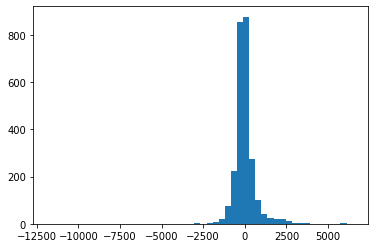

In [105]:
plt.hist(residuo, bins=50);

In [106]:
pd.Series(residuo).describe()

count    2.580000e+03
mean     5.710781e-14
std      6.917907e+02
min     -1.180092e+04
25%     -3.038095e+02
50%     -6.785133e+01
75%      1.835001e+02
max      6.476814e+03
Name: vote_count, dtype: float64

#### **ÁRVORE DE DECISÃO:**

In [107]:
# Árvore de decisão
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=RANDOM_SEED)
tree_reg.fit(movies, movies_labels)

DecisionTreeRegressor(random_state=42)

In [108]:
predicted_labels = tree_reg.predict(movies)
print('Predição: {}'.format(predicted_labels))
print('Original: {}'.format(movies_labels.values))

Predição: [1599.  507. 1685. ... 1360. 1267.  206.]
Original: [1599  507 1685 ... 1360 1267  206]


In [109]:
movies_predictions = tree_reg.predict(movies)
tree_mse = mean_squared_error(movies_labels, movies_predictions)
tree_rmse = np.sqrt(tree_mse)
print('Árvore de decisão: RMSE = {:.2f}'.format(tree_rmse))

Árvore de decisão: RMSE = 0.00


#### Overfitting!

#### **RANDOM FOREST:**

In [110]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=RANDOM_SEED)

In [111]:
forest_reg.fit(movies, movies_labels)

y_pred = forest_reg.predict(movies)
forest_rmse = np.sqrt(mean_squared_error(movies_labels, movies_predictions))
print('Regressão random forest: RMSE = {:.2f}'.format(forest_rmse))

Regressão random forest: RMSE = 0.00


#### Overfitting!

### Melhorando nossa avaliação usando validação cruzada

Primeiramente, é necessário dividir os dados de treinamento novamente para análise dos modelos

In [112]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    movies,
    movies_labels,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

In [113]:
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
lin_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão linear: RMSE = {:.2f}'.format(lin_rmse))

Regressão linear: RMSE = 868.70


In [114]:
tree_reg.fit(X_train, y_train)

y_pred = tree_reg.predict(X_test)
tree_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Árvore de decisão: RMSE = {:.2f}'.format(tree_rmse))

Árvore de decisão: RMSE = 621.17


In [115]:
forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão random forest: RMSE = {:.2f}'.format(forest_rmse))

Regressão random forest: RMSE = 441.39


In [116]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(
    lin_reg,  # modelo
    movies,  # X_train
    movies_labels,  # y_train
    scoring='neg_mean_squared_error',  # metrica de interesse
    cv=10,  # Quantas partições eu quero
    n_jobs=-1,  # Use todos os cores da maquina!
)
lin_rmse_scores = np.sqrt(-lin_scores)


def display_scores(scores):
    print('Scores:', scores.round(decimals=2))
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())


display_scores(lin_rmse_scores)

Scores: [ 526.65  646.07  744.82  705.8   641.17  745.81 1195.63  782.2   567.45
  591.51]
Mean: 714.7101006840752
Standard deviation: 178.92407627225498


In [117]:
tree_scores = cross_val_score(
    tree_reg,
    movies,
    movies_labels,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [613.54 878.52 850.35 876.48 701.74 803.09 819.42 861.1  933.06 761.87]
Mean: 809.917288936317
Standard deviation: 90.14767925074057


In [118]:
forest_scores = cross_val_score(
    forest_reg,
    movies,
    movies_labels,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [433.13 598.18 724.77 647.08 563.56 683.   576.71 587.02 451.24 549.28]
Mean: 581.3972749316347
Standard deviation: 87.06449879331575


Text(0.5, 1.0, 'RMSE / Regressor')

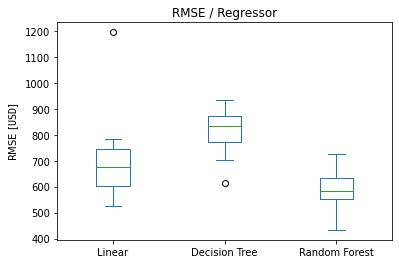

In [119]:
pd.DataFrame({
    'Linear': lin_rmse_scores,
    'Decision Tree': tree_rmse_scores,
    'Random Forest': forest_rmse_scores,
}).plot.box();
plt.ylabel(r'RMSE $[\mathtt{USD}]$')
plt.title("RMSE / Regressor")

Melhor modelo: Regressão Random Forest

In [120]:
# Para obter as previsões, basta chamar o método predict()
predicted_labels = forest_reg.predict(movies)
print('Predição: {}'.format(predicted_labels.round(decimals=2)))

# Compare com os valores originais:
print('Original: {}'.format(movies_labels.values.round(decimals=2)))

Predição: [1741.8  624.6 1570.7 ... 1444.7 1524.7  167.6]
Original: [1599  507 1685 ... 1360 1267  206]


In [124]:
movies_['title'][0]

'Avatar'

In [128]:
movies_['vote_count'][0]

11800

In [126]:
predicted_labels[0]

1741.8